In [9]:
import numpy as np
import models
import metrics
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose

# Carregando os dados

In [10]:
us_change = pd.read_csv('us_change.csv')


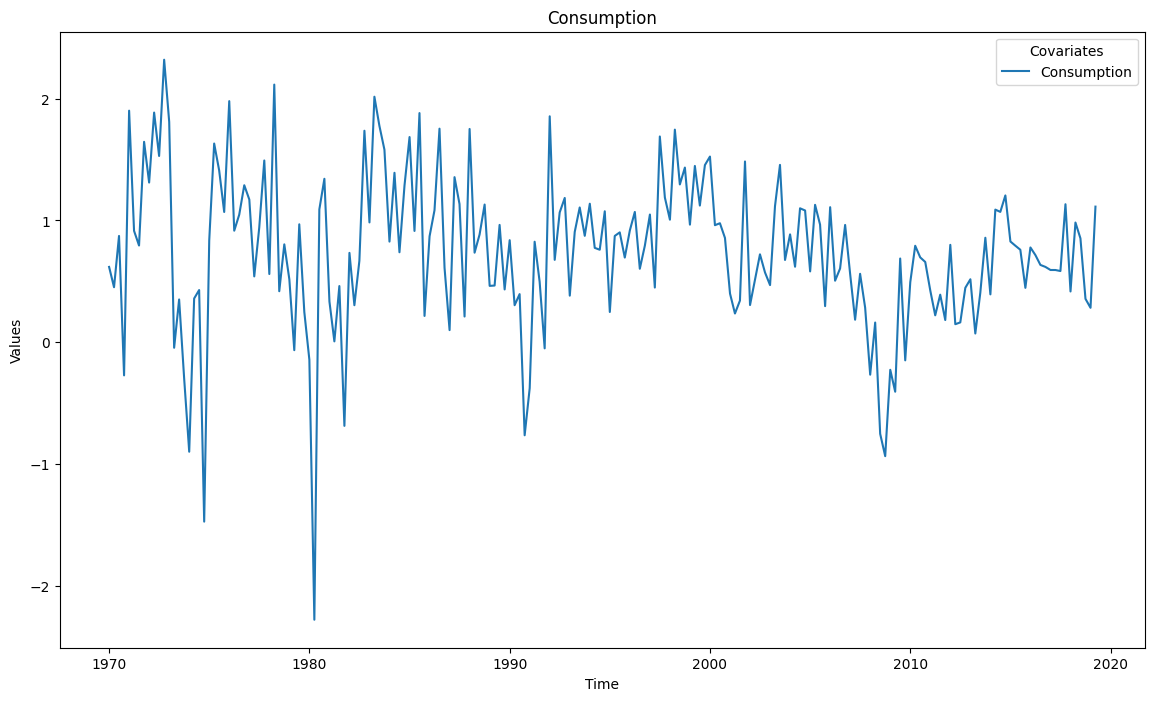

In [11]:
# Convert the 'Quarter' column to datetime format
def parse_quarter(quarter_str):
    year, quarter = quarter_str.split(' ')
    month = (int(quarter[1]) - 1) * 3 + 1
    return pd.Timestamp(f'{year}-{month:02d}-01')

us_change['Quarter'] = us_change['Quarter'].apply(parse_quarter)

# Set the 'Quarter' column as the index
us_change.set_index('Quarter', inplace=True)

# Plot all covariates as time series
plt.figure(figsize=(14, 8))
sns.lineplot(data=us_change['Consumption'], label='Consumption')
plt.title('Consumption')
plt.xlabel('Time')
plt.ylabel('Values')
plt.legend(title='Covariates')
plt.show()

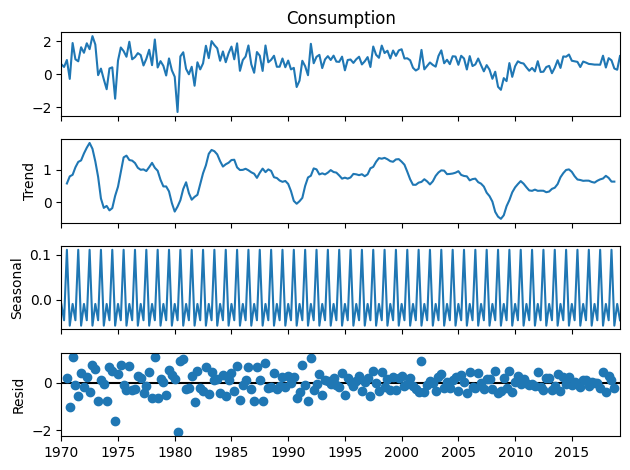

In [16]:
# Decompose the time series
decomposition = seasonal_decompose(us_change['Consumption'], model='additive')
decomposition.plot()
plt.show()

# Modelos baselines

In [13]:
naive = models.NaiveModel()
naive.fit(us_change['Consumption'])

seasonal_naive = models.SeasonalNaiveModel(4)
seasonal_naive.fit(us_change['Consumption'])

average_model = models.AverageModel()
average_model.fit(us_change['Consumption'])

drift_model = models.DriftModel()
drift_model.fit(us_change['Consumption'])

# Create a DataFrame with the predictions
predictions = pd.DataFrame({
    'Naive': naive.predict(12),
    'Seasonal Naive': seasonal_naive.predict(12),
    'Average': average_model.predict(12),
    'Drift': drift_model.predict(12)
    })

predictions

/home/vinicius/Documents/GitHub/time-series/models.py:30: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return np.repeat(self.y_train[-1], n_preds)
/home/vinicius/Documents/GitHub/time-series/models.py:87: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return np.arange(1, n_preds + 1) * (self.y_train[-1] - self.y_train[0]) / len(self.y_train) + self.y_train[-1]


,Naive,Seasonal Naive,Average,Drift
0,1.113517,0.853181,0.742482,1.116016
1,1.113517,0.356512,0.742482,1.118516
2,1.113517,0.282885,0.742482,1.121016
3,1.113517,1.113517,0.742482,1.123516
4,1.113517,0.853181,0.742482,1.126015
5,1.113517,0.356512,0.742482,1.128515
6,1.113517,0.282885,0.742482,1.131015
7,1.113517,1.113517,0.742482,1.133515
8,1.113517,0.853181,0.742482,1.136014
9,1.113517,0.356512,0.742482,1.138514


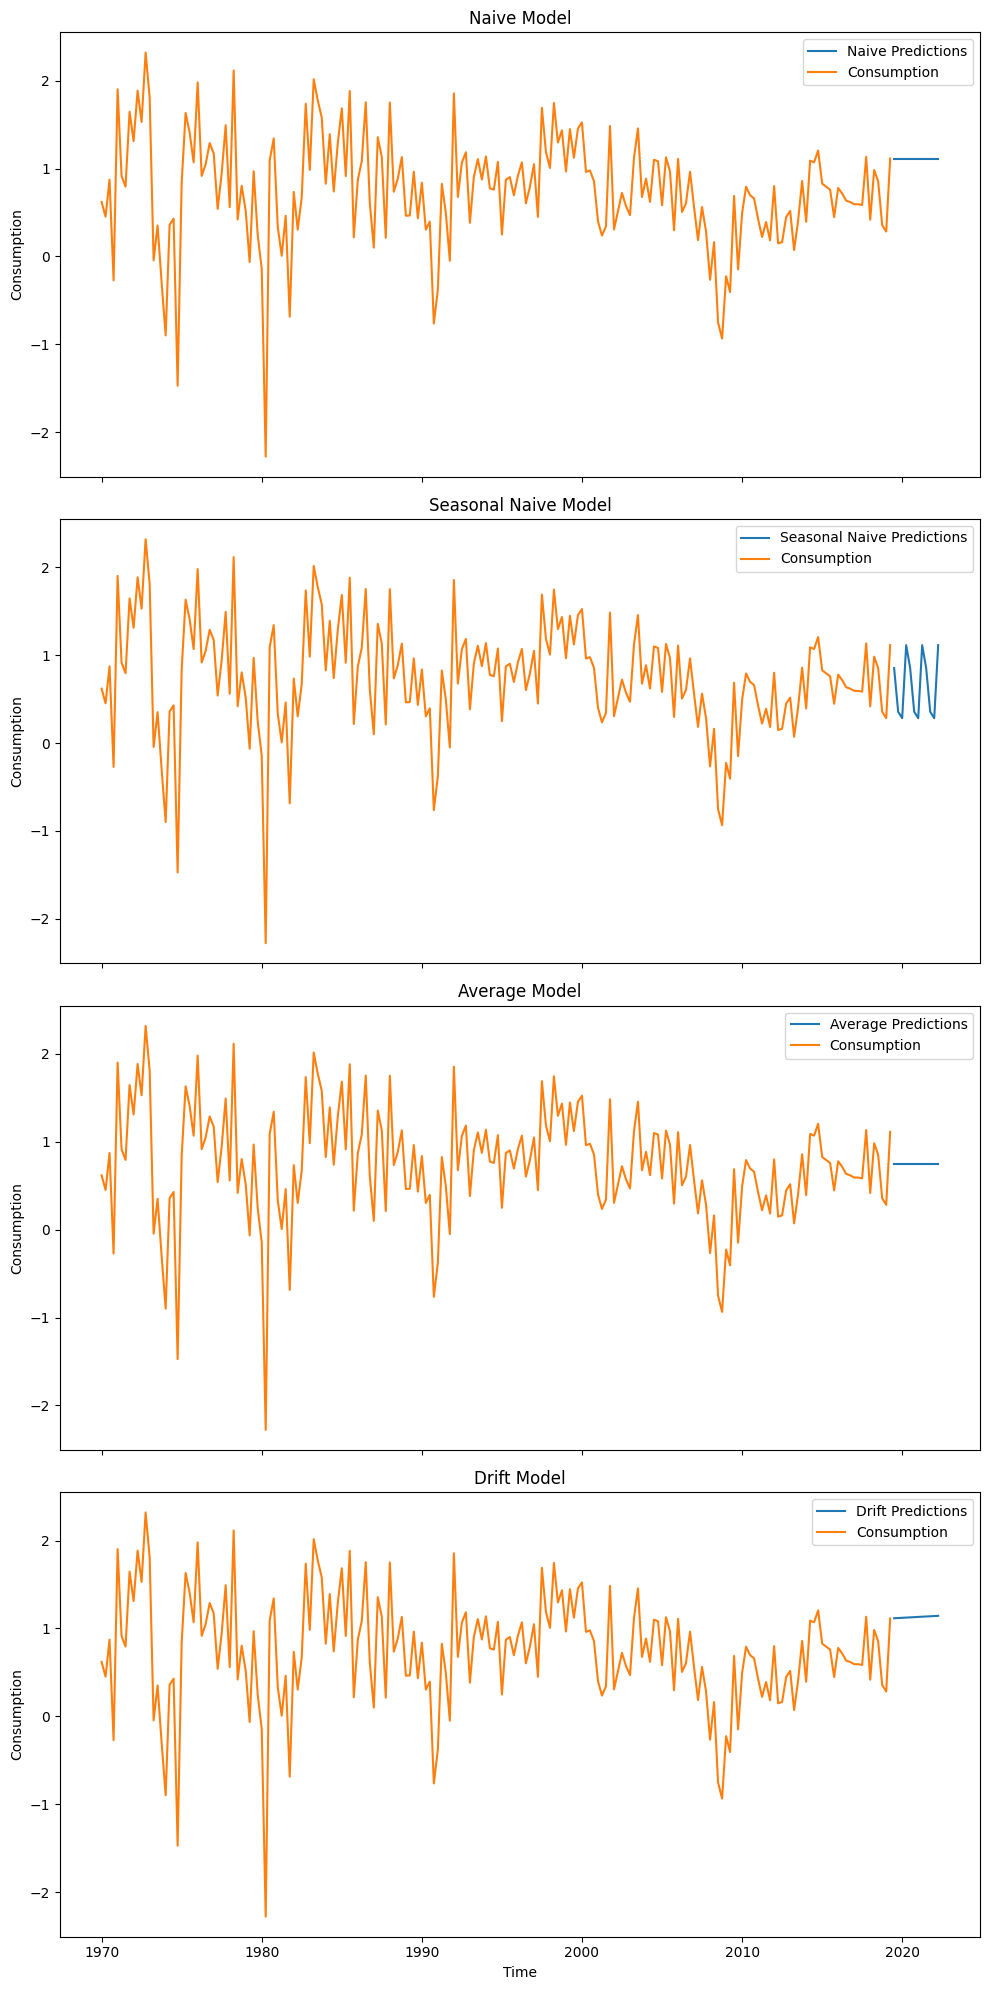

In [14]:
fig, axes = plt.subplots(4, 1, figsize=(10, 20), sharex=True)

models = ['Naive', 'Seasonal Naive', 'Average', 'Drift']
for ax, model in zip(axes.flatten(), models):
    # Create a new series for the predictions
    prediction_series = pd.Series(predictions[model].values, 
                                  index=pd.date_range(start=us_change.index[-1], periods=12, freq='QE'))
    
    
    # Plot the prediction series
    sns.lineplot(data=prediction_series, ax=ax, label=f'{model} Predictions')
    
    #plot consumption data
    sns.lineplot(data=us_change['Consumption'], ax=ax, label='Consumption')
    
    ax.set_title(f'{model} Model')
    ax.set_xlabel('Time')
    ax.set_ylabel('Consumption')

plt.tight_layout()
plt.show()